# 5.3 Images

In [2]:
%matplotlib inline

In [17]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datasets import load_dataset

from tqdm.auto import tqdm, trange

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [18]:
# Training data
train = datasets.MNIST("", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

# Testing data
test = datasets.MNIST("", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)


In [19]:
def viz_img(mat):
    if mat.shape.__len__() == 3:
        mat = mat.squeeze(0)
        
    plt.imshow(mat.numpy())

def viz_pred(logits):
    plt.figure()
    plt.bar(np.arange(0, 10), logits.squeeze(0).detach().numpy())
    plt.xticks(np.arange(0, 10))

    plt.show()
    

Idx:  51556 Corresponding label:  1


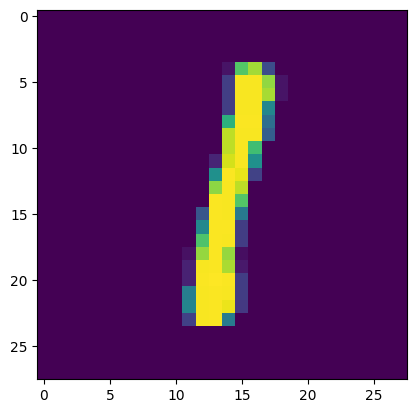

In [20]:
# See the image and the label
i = torch.randint(0, len(train)-1, (1,)).item()
viz_img(train[i][0])

print(f'Idx: {i:6d} Corresponding label: ', train[i][1])

In [21]:
class NonLinCLf(torch.nn.Module):
    
    def __init__(self, input_dim: int, n_classes: int):
        super().__init__()
        self.l1 = torch.nn.Linear(input_dim, 100)
        self.l2 = torch.nn.Linear(100, n_classes)

    def forward(self, x):
        x = self.l1(x)
        # act
        x = torch.relu(x)
        x = self.l2(x)
        return x


In [22]:
model = NonLinCLf(784, 10)
lfn = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.01)
epochs = 20

In [ ]:

for epoch in trange(epochs):
    for batch in train_loader:
        inputs, target = batch
        opt.zero_grad()
        preds = model(inputs.reshape(-1, 784))
        loss = lfn(preds, target)
        loss.backward()
        opt.step()

        

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:51<00:00,  2.58s/it]


torch.Size([1, 28, 28]) 2


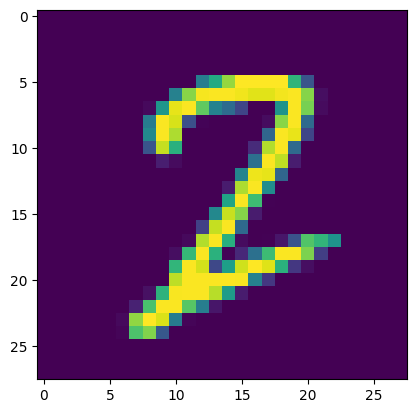

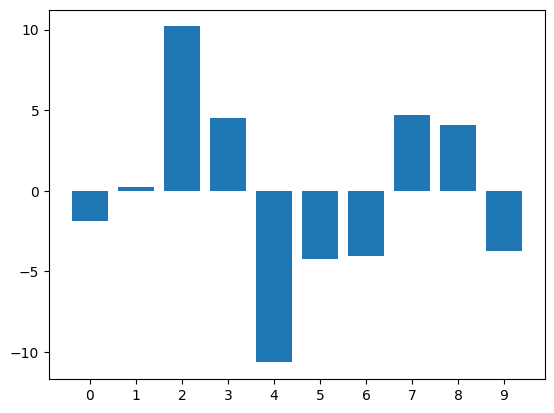

/var/folders/9x/4f0vzwcs4x70z_krjbkswnk80000gq/T/ipykernel_68134/2334209317.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  viz_pred(F.softmax(pred))


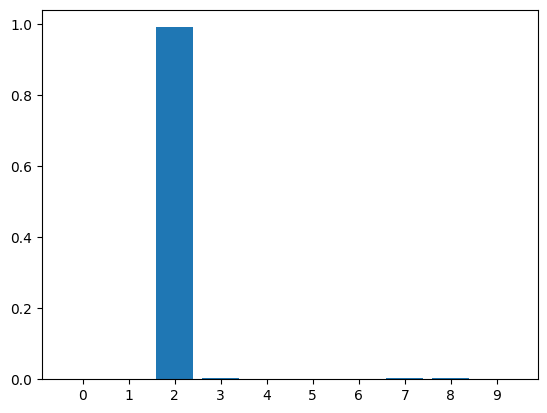

In [28]:
i = 404
print(test[i][0].shape, test[i][1])
viz_img(test[i][0])

pred = model(test[i][0].reshape(-1, 28*28))
viz_pred(pred)
viz_pred(F.softmax(pred))

In [27]:
test.test_data.shape

/Users/priyansh.trivedi/Dev/learning/dl-workinggroup/.venv/lib/python3.12/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


torch.Size([10000, 28, 28])

In [29]:
# Lets calculate its real performance?
test_data = test.test_data.reshape(-1, 784).to(torch.float32)
test_logits = model(test_data)
(torch.argmax(test_logits, dim=1) == test.test_labels).to(torch.float32).mean()

/Users/priyansh.trivedi/Dev/learning/dl-workinggroup/.venv/lib/python3.12/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


tensor(0.9763)

# Lets look at another very famous dataset



In [30]:
import torch
from torchvision import transforms
from datasets import load_dataset
from torch.utils.data import DataLoader

# 1. Load the dataset from Hugging Face
ds = load_dataset("uoft-cs/cifar10")
train_ds = ds['train']
test_ds = ds['test']

# 2. Define a simple transformation
transform = transforms.Compose([
    transforms.ToTensor() # Converts PIL image to PyTorch tensor and scales to [0,1]
])

# 3. Create a function to apply transformations
def apply_transforms(examples):
    examples['inputs'] = [transform(image.convert("RGB")) for image in examples['img']]
    return examples

# 4. Apply transformations to the datasets
train_ds.set_transform(apply_transforms, columns=['img', 'label'], output_all_columns=False)
test_ds.set_transform(apply_transforms, columns=['img', 'label'], output_all_columns=False)


# 5. Define a collate function
def collate_fn(batch):
    pixel_values = torch.stack([example['inputs'] for example in batch])
    labels = torch.tensor([example['label'] for example in batch])
    return {'inputs': pixel_values, 'label': labels}

# 6. Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=10, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=10, shuffle=False, collate_fn=collate_fn)


In [31]:
for batch_idx, batch in enumerate(train_loader):
    images = batch['inputs']
    labels = batch['label']
    print(f"Batch {batch_idx + 1}:")
    print("Images shape:", images.shape) # Should be [batch_size, 3, 32, 32]
    print("Labels shape:", labels.shape)   # Should be [batch_size]
    print("Labels in the batch:", labels)
    if batch_idx == 0: # Check only the first batch
        break

Batch 1:
Images shape: torch.Size([10, 3, 32, 32])
Labels shape: torch.Size([10])
Labels in the batch: tensor([3, 9, 9, 9, 1, 2, 3, 8, 7, 6])


## Exploring the data

In [32]:
ds['train'].features['label']

ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)

(32, 32, 3) 4


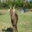

In [33]:
print(np.array(ds['train'][20]['img']).shape, ds['train'][20]['label'])
ds['train'][20]['img']

In [34]:
## how many labels
ds['train']

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

In [35]:
## Testing dataloaders
for batch in train_loader:
    inputs, label = batch.values()
    break

inputs.shape, label.shape

(torch.Size([10, 3, 32, 32]), torch.Size([10]))

### Training on this dataset

In [36]:
model = NonLinCLf(3*32*32, 10)
lfn = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.01)
epochs = 20

In [37]:
# Training on it
for epoch in trange(epochs):
    for batch in train_loader:
        inputs, label = batch.values()
        opt.zero_grad()
        preds = model(inputs.reshape(-1, 3*32*32))
        loss = lfn(preds, label)
        loss.backward()
        opt.step()

        

100%|██████████| 20/20 [01:59<00:00,  5.96s/it]


### Does it work?

In [41]:
test_logits = []
test_labels = []
for batch in tqdm(test_loader):
    inputs, target = batch.values()
    with torch.no_grad():
        logits = model(inputs.reshape(-1, 3*32*32))
    test_logits.append(logits)
    test_labels.append(target)



100%|██████████| 1000/1000 [00:00<00:00, 1136.22it/s]


In [42]:
test_logits = torch.cat(test_logits)
test_labels = torch.cat(test_labels)


In [ ]:
(torch.argmax(test_logits, dim=1) == test_labels).to(torch.float32).mean()

tensor(0.4875)

# What did we do here?

We flattened the image out into a set of pixels. Each pixel contained some information (value between 0 and 1) but it also had some information based on its neighbours. We took away this information.

# What else can we do?

In [45]:
# Lets load an image
from pathlib import Path
imgpath = Path('../resources/grumpycat.jpg')
assert imgpath.exists()

ANIMATION_PAUSE_DURATION = 0.0005
target_image_size = (60, 60)

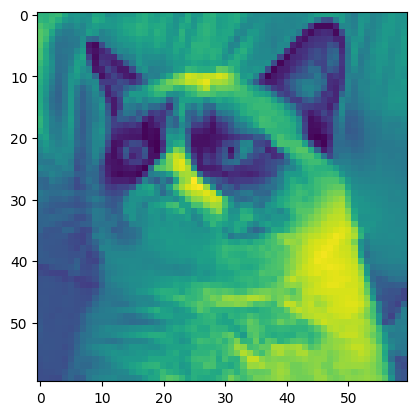

In [46]:
import numpy as np
from PIL import Image, ImageOps # Pillow for image manipulation
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython import display # For updating the plot in Jupyter
import time # For plt.pause
def prepimage(image_path_str, target_size):
    """
    Loads an image, converts it to grayscale, resizes it, and returns it as a NumPy array.
    If the image is not found, a placeholder gradient image is created.
    """
    # Open the image using Pillow
    img = Image.open(image_path_str)
    # Convert to grayscale ('L' mode)
    img_gray = img.convert('L')
    # Resize and crop to the target size to maintain aspect ratio
    img_resized = ImageOps.fit(img_gray, target_size, Image.Resampling.LANCZOS)
    # Convert the PIL image to a NumPy array
    return np.array(img_resized)


imgnp = prepimage(imgpath, target_image_size)
img_height, img_width = imgnp.shape
viz_img(torch.tensor(imgnp))

In [47]:
# kernel = np.array([
#     [-1, -2, -1],
#     [ 0,  0,  0],
#     [ 1,  2,  1]
# ])

kernel = np.array([
    [-1, -1, -1, -1, -1],
    [-1, -1, -1, -1, -1],
    [ 0,  0,  0,  0,  0],
    [ 1,  1,  1,  1,  1],
    [ 1,  1,  1,  1,  1]
])

In [48]:
# Output Feature Map Initialization

k_height, k_width = kernel.shape
output_height = img_height - k_height + 1
output_width = img_width - k_width + 1

# Initialize the output feature map with zeros
output_feature_map = np.zeros((output_height, output_width))

# Some book keeping
print("Starting convolution visualization...")
print(f"Input image size: {imgnp.shape}")
print(f"Kernel size: {kernel.shape}")
print(f"Output map size: {output_feature_map.shape}")

# Determine a reasonable color scale for the output. Sobel can produce negative values.
# Max possible activation value (absolute) can be estimated.
max_abs_activation = np.sum(np.abs(kernel)) * 255

Starting convolution visualization...
Input image size: (60, 60)
Kernel size: (5, 5)
Output map size: (56, 56)


In [49]:
# Iterate over each position where the kernel can be placed on the input image
for y_out in range(output_height):
    for x_out in range(output_width):
        # y_in, x_in are the top-left coordinates of the kernel's current window on the input image
        y_in = y_out
        x_in = x_out

        # Extract the region of interest (ROI) from the input image
        # This is the patch of the image that the kernel is currently overlapping
        roi = imgnp[y_in : y_in + k_height, x_in : x_in + k_width]

        # Perform the core convolution operation:
        # Element-wise multiplication of the ROI and the kernel, then sum the results
        activation = np.sum(roi * kernel)

        # Store the calculated activation in the output feature map
        output_feature_map[y_out, x_out] = activation

        # --- Update Visualization (Recreate plot in each step) ---
        display.clear_output(wait=True)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        # Subplot 1: Input image and the sliding kernel box
        ax1.set_title(f"Input (Step {y_out*output_width + x_out + 1}/{output_height*output_width})")
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.imshow(imgnp, cmap='gray', vmin=0, vmax=255)
        kernel_box = patches.Rectangle((x_in - 0.5, y_in - 0.5), k_width, k_height,
                                       linewidth=1.5, edgecolor='r', facecolor='none')
        ax1.add_patch(kernel_box)

        # Subplot 2: Output feature map (activations)
        ax2.set_title("Output Feature Map")
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.imshow(output_feature_map, cmap='coolwarm',
                   vmin=-max_abs_activation, vmax=max_abs_activation)

        fig.tight_layout()
        plt.show()

        # # Pause to control animation speed
        # if ANIMATION_PAUSE_DURATION > 0:
        #     time.sleep(ANIMATION_PAUSE_DURATION)


KeyboardInterrupt: 

# Doing it in torch

In [50]:
class ImgClf(nn.Module):
    def __init__(self, n_classes: int=10):
        super().__init__()
        # Input: bs x 3 x 32 x 32 (R G B and each having 32 x 32 pixels)

        # Conv layer 1: Input: bs x 3 x 32 x 32. Output: bs x 16 x 32 x 32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # Will do pooling in forward so Output bs x 16 x 16 x 16

        # Conv layer 2: Input: bs x 16 x 16 x 16. Output: bs x 32 x 16 x 16
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Will do pooling in forward so Output bs x 16 x 8 x 8

        # Define the pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Then we do MLP over this representation of data
        self.mlp1 = nn.Linear(32*8*8, 128)
        self.mlp2 = nn.Linear(128, n_classes)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten
        x = x.reshape(-1,32*8*8)

        # Apply MLP and activations
        x = F.relu(self.mlp1(x))
        return self.mlp2(x)



In [51]:
model = ImgClf(10)
lfn = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.01)
epochs = 20

In [52]:
# Training on it
for epoch in trange(epochs):
    for batch in train_loader:
        opt.zero_grad()
        inputs, label = batch.values()
        preds = model(inputs)
        loss = lfn(preds, label)
        loss.backward()
        opt.step()

        

100%|██████████| 20/20 [04:05<00:00, 12.25s/it]


In [54]:
# Testing?
test_logits = []
test_labels = []
for batch in tqdm(test_loader):
    inputs, target = batch.values()
    with torch.no_grad():
        logits = model(inputs)
    test_logits.append(logits)
    test_labels.append(target)

test_logits = torch.cat(test_logits)
test_labels = torch.cat(test_labels)



100%|██████████| 1000/1000 [00:01<00:00, 604.72it/s]


In [55]:
(torch.argmax(test_logits, dim=1) == test_labels).to(torch.float32).mean()

tensor(0.6775)